In [1]:
## Fast Import
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
import pathlib
import time
import math, random
import pprint
import collections
import numbers, string

import yaml
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import albumentations as A

np.set_printoptions(precision=3)
curr_path = pathlib.Path(os.getcwd()).absolute()

cards = !echo $SGE_HGR_gpu_card
device = torch.device(f"cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Visualize Batches

In [25]:
from configs import get_config
cfg = get_config('./experiments/pgl/configs/pgl_train.yaml', merge_default=False)
cfg.train.train_byol = False

from experiments.pgl.data_setup import get_data_components
data_d = get_data_components(cfg)
train_loader = data_d['train_loader']    

 > Loading config (./experiments/pgl/configs/pgl_train.yaml).. done.
💠 PreprocessSampleSet created w/ 1029 samples.
[Took 1.04 sec.]
💠 OTMLoader created w/ 1029 train samples. 
   BatchSize=12, CropsPerVolume=8, ShuffleSamples/Patches=True, NumWorkers=2.


24 0 12


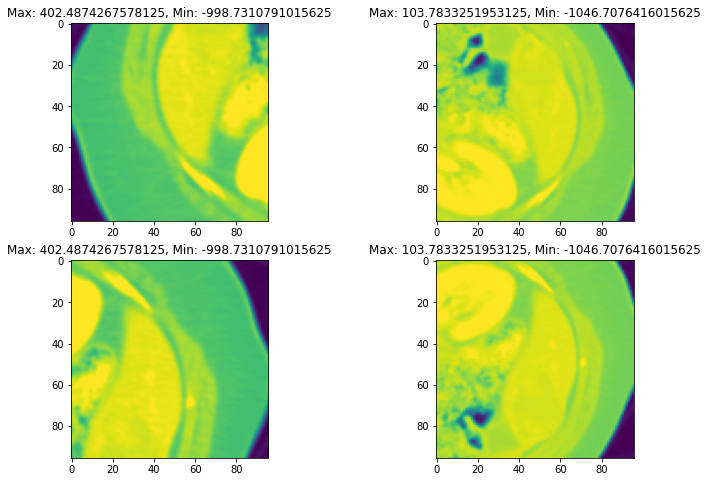

OrderedDict([('ReadImage', {'shape': torch.Size([44, 512, 512])}),
             ('Clamp', {'max': 325, 'min': -1024}),
             ('ZNormalize',
              {'mean': -727.2110595703125, 'std': 440.1143798828125}),
             ('ScaledOverlapCrop3d',
              {'final_relative_overlap': {'lower': [0.0,
                                                    3.2727272727272725,
                                                    0.0],
                                          'upper': [32.0,
                                                    96.0,
                                                    90.4186046511628]},
               'final_shape': [32, 96, 96],
               'init_lower': [4, 191, 327],
               'init_overlap': {'init_iou': 0.4992386338916685,
                                'lower': [4, 194, 327],
                                'shape': [32, 85, 81],
                                'upper': [36, 279, 408]},
               'init_shape': [32, 88, 86],
      

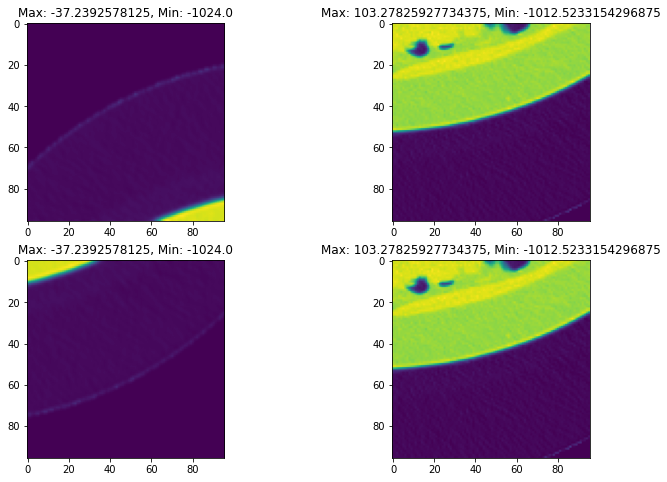

OrderedDict([('ReadImage', {'shape': torch.Size([104, 512, 512])}),
             ('Clamp', {'max': 325, 'min': -1024}),
             ('ZNormalize',
              {'mean': -564.2037353515625, 'std': 489.6400451660156}),
             ('ScaledOverlapCrop3d',
              {'final_relative_overlap': {'lower': [0.0, 0.0, 0.0],
                                          'upper': [32.0,
                                                    63.47107438016529,
                                                    61.02325581395349]},
               'final_shape': [32, 96, 96],
               'init_lower': [6, 382, 317],
               'init_overlap': {'init_iou': 0.24906032879000722,
                                'lower': [6, 382, 317],
                                'shape': [32, 80, 82],
                                'upper': [38, 462, 399]},
               'init_shape': [32, 121, 129],
               'init_upper': [38, 503, 446]}),
             ('Flip3d',
              {'flipped_flags': [Tru

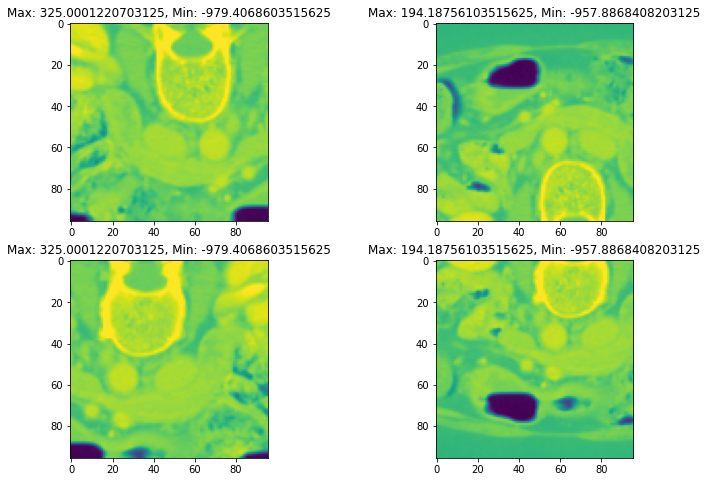

OrderedDict([('ReadImage', {'shape': torch.Size([44, 512, 512])}),
             ('Clamp', {'max': 325, 'min': -1024}),
             ('ZNormalize',
              {'mean': -727.2110595703125, 'std': 440.1143798828125}),
             ('ScaledOverlapCrop3d',
              {'final_relative_overlap': {'lower': [0.0,
                                                    14.49056603773585,
                                                    0.0],
                                          'upper': [32.0,
                                                    96.0,
                                                    70.22222222222221]},
               'final_shape': [32, 96, 96],
               'init_lower': [2, 210, 204],
               'init_overlap': {'init_iou': 0.3652522346655707,
                                'lower': [2, 226, 204],
                                'shape': [32, 90, 79],
                                'upper': [34, 316, 283]},
               'init_shape': [32, 106, 108],
    

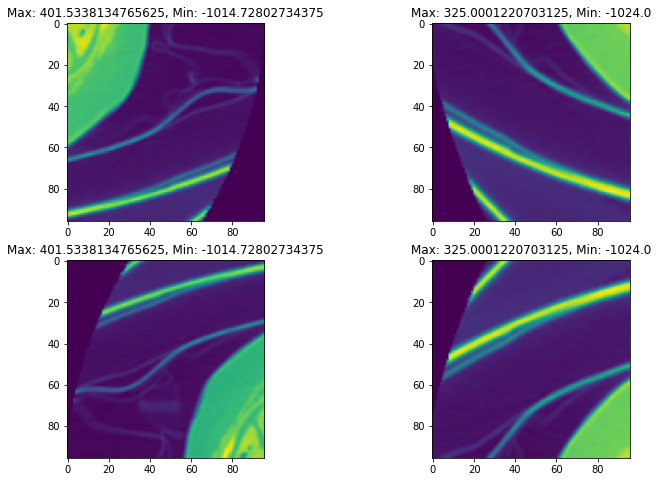

OrderedDict([('ReadImage', {'shape': torch.Size([44, 512, 512])}),
             ('Clamp', {'max': 325, 'min': -1024}),
             ('ZNormalize',
              {'mean': -727.2110595703125, 'std': 440.1143798828125}),
             ('ScaledOverlapCrop3d',
              {'final_relative_overlap': {'lower': [0.0, 0.0, 9.29032258064516],
                                          'upper': [32.0,
                                                    58.53658536585366,
                                                    96.0]},
               'final_shape': [32, 96, 96],
               'init_lower': [4, 117, 1],
               'init_overlap': {'init_iou': 0.5021220634825752,
                                'lower': [4, 117, 13],
                                'shape': [32, 75, 112],
                                'upper': [36, 192, 125]},
               'init_shape': [32, 123, 124],
               'init_upper': [36, 240, 125]}),
             ('Flip3d',
              {'flipped_flags': [True, T

SystemExit: 1

In [26]:
## Visualize patches
from data.transforms import z_normalize, flip


for it, batch in enumerate(train_loader):
    samples = batch['samples']
    records = batch['records']
    crop_objs = batch['crops']

    X = batch['X'].to(device, non_blocking=True)
    
    for pair_i in range(len(X) // 2):
        im1_idx = pair_i
        im2_idx = pair_i + len(X) // 2
        print(len(X), im1_idx, im2_idx)
        
        tens1 = X[im1_idx].squeeze()
        tens2 = X[im2_idx].squeeze()
        
        hist1, hist2 = records[pair_i]
        
        un_tens1 = z_normalize.ZNormalize().invert(tens1, hist1['ZNormalize'])
        un_tens2 = z_normalize.ZNormalize().invert(tens2, hist2['ZNormalize'])
                
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(2, 2, 1)
        ax.set_title(f'Max: {un_tens1.max().item()}, Min: {un_tens1.min().item()}')
        ax.imshow(un_tens1[tens1.shape[0] // 2].cpu().numpy().astype(np.int16))
        ax = fig.add_subplot(2, 2, 2)
        ax.set_title(f'Max: {un_tens2.max().item()}, Min: {un_tens2.min().item()}')
        ax.imshow(un_tens2[tens2.shape[0] // 2].cpu().numpy().astype(np.int16))
        
        un_tens1 = flip.Flip3d().invert(un_tens1, hist1['Flip3d'])
        un_tens2 = flip.Flip3d().invert(un_tens2, hist2['Flip3d'])
        
        ax = fig.add_subplot(2, 2, 3)
        ax.set_title(f'Max: {un_tens1.max().item()}, Min: {un_tens1.min().item()}')
        ax.imshow(un_tens1[tens1.shape[0] // 2].cpu().numpy().astype(np.int16))
        ax = fig.add_subplot(2, 2, 4)
        ax.set_title(f'Max: {un_tens2.max().item()}, Min: {un_tens2.min().item()}')
        ax.imshow(un_tens2[tens2.shape[0] // 2].cpu().numpy().astype(np.int16))
        plt.show()
        
        pprint.pprint(hist1)
        pprint.pprint(hist2)
        
        if pair_i >= 3:
            import sys; sys.exit(1)
    

# PGL Model + Crit + Optim + Scheduler Setup

In [8]:
from experiments.pgl.pgl_unet3d import UNet3D
from lib.nets.ema import create_ema_model, update_ema_model

model = UNet3D(n_input=1, n_class=1, act='relu')
ema_model = create_ema_model(UNet3D(n_input=1, n_class=1, act='relu'))
model, ema_model = model.to(device), ema_model.to(device)
if True:
    print(f'  * {-1} GPUs, using nn.DataParallel.')
    model = nn.DataParallel(model)
    ema_model = nn.DataParallel(ema_model)

💠 UNet3D-PGL model initiated with n_classes=1, 
   n_input=1, activation=relu, 
   params=19,073,665, trainable_params=19,073,665.
💠 UNet3D-PGL model initiated with n_classes=1, 
   n_input=1, activation=relu, 
   params=19,073,665, trainable_params=19,073,665.
  * -1 GPUs, using nn.DataParallel.


In [30]:
from lib.assess.losses3d import BYOL3d

criterion = BYOL3d()

# Test criterion 
pred = torch.randn((200, 1, 96, 96, 16))
targ = torch.randn((200, 1, 96, 96, 16))

# BYOL 2 - 2 * .. loss
def byol1(pred, targ):
    pred = pred.view(pred.shape[0], -1)
    targ = targ.view(targ.shape[0], -1)
    pred_norm = F.normalize(pred, dim=-1, p=2)
    targ_norm = F.normalize(targ, dim=-1, p=2)
    loss = torch.sum(2 - 2 * (pred_norm * targ_norm).sum(dim=-1)) / pred.shape[0]
    print(loss)
    return loss

def byol2(pred, targ):
    pred = pred.view(pred.shape[0], -1)
    targ = targ.view(targ.shape[0], -1)
    pred_norm = F.normalize(pred, dim=-1, p=2)
    targ_norm = F.normalize(targ, dim=-1, p=2)
    loss = ((pred_norm - targ_norm) ** 2).sum() / pred.shape[0]
    print(loss, '-')
    return loss

times1 = np.zeros(10)
times2 = np.zeros(10)
for i in range(10):
    start = time.time()
    byol1(pred, targ)
    times1[i] = time.time() - start
    
    start = time.time()
    byol2(pred, targ)
    times2[i] = time.time() - start
print(f'1: {times1.mean():.3f}, 2: {times2.mean():.3f}')


💠 Criterion: BYOL3d initiated.
1: 0.089, 2: 0.116


# PGL Data Setup

In [4]:
from experiments.pgl import data_setup

data_setup.get_data_components(None)
